In [3]:
import os
import json
import string
import warnings
import pandas as pd
import seaborn as sns
from synthesized.testing import synthetic_distributions as syn_dist

warnings.filterwarnings(action='ignore', message='numpy.dtype size changed')
warnings.filterwarnings(action='ignore', message='compiletime version 3.5 of module')

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from synthesized.testing.evaluation import Evaluation
branch = os.environ.get('EVALUATION_BRANCH', 'n/a')
revision = os.environ.get('EVALUATION_REVISION', 'n/a')
group = "synthetic"
config_path = os.environ.get('EVALUATION_CONFIG_PATH', 'n/a')
with open(config_path, 'r') as f:
    configs = json.load(f)
    config = configs["instances"]["synthetic"]
evaluation = Evaluation(branch=branch, revision=revision, group=group) # use this line if you want to run this notbook manually
# evaluation = Evaluation()

In [5]:
from synthesized.testing import UtilityTesting

In [6]:
from synthesized import HighDimSynthesizer

In [7]:
import numpy as np

In [8]:
def plot_data(data, ax=None):
    if data.shape[1] == 1:
        if data['x'].dtype.kind == 'O':
            return sns.countplot(data["x"], ax=ax)
        else:
            return sns.distplot(data["x"], ax=ax)
    if data.shape[1] == 2:
        if data['x'].dtype.kind == 'O' and data['y'].dtype.kind == 'f':
            order = sorted(data["x"].unique().tolist())
            sns.violinplot(x="x", y="y", data=data, ax=ax)
        elif data['x'].dtype.kind == 'f' and data['y'].dtype.kind == 'f':
            #return sns.jointplot(x="x", y="y", data=data, kind="kde", ax=ax)
            return ax.hist2d(data['x'], data['y'], bins=100)
        elif data['x'].dtype.kind == 'O' and data['y'].dtype.kind == 'O':
            crosstab = pd.crosstab(data['x'], columns=[data['y']]).apply(lambda r: r/r.sum(), axis=1)
            sns.heatmap(crosstab, vmin=0.0, vmax=1.0, ax=ax)
        else:
            return sns.distplot(data, ax=ax)
    else:
        return sns.distplot(data, ax=ax)

###  Evaluation metrics

In [9]:
def max_correlation_distance(orig, synth):
    return np.abs((orig.corr() - synth.corr()).to_numpy()).max()

def mean_ks_distance(orig, synth):
    distances = [ks_2samp(orig[col], synth[col])[0] for col in orig.columns]
    return np.mean(distances)

In [10]:
import time
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt



default_metrics = {"avg_distance": mean_ks_distance}

def synthesize_and_plot(data, name, n_iter=config['num_iterations'], metrics=None, 
                        show_anova=False, show_cat_rsquared=False):
    evaluation.record_config(evaluation=name, config=config)
    start = time.time()
    with HighDimSynthesizer(df=data, **config['params']) as synthesizer:
        synthesizer.learn(df_train=data, num_iterations=n_iter)
        synthesized = synthesizer.synthesize(num_rows=len(data))
        print('took', time.time() - start, 's')
        print("Metrics:")
        for key, metric in metrics.items():
            value = metric(orig=data, synth=synthesized)
            evaluation.record_metric(evaluation=name, key=key, value=value)
            print(f"{key}: {value}")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
        ax1.set_title('orig')
        ax2.set_title('synth')
        plot_data(data, ax=ax1)
        plot_data(synthesized, ax=ax2)
        if show_anova:
            testing = UtilityTesting(synthesizer, data, data, synthesized)
            testing.show_anova()
        if show_cat_rsquared:
            testing = UtilityTesting(synthesizer, data, data, synthesized)
            testing.show_categorical_rsquared()

### Gauss "ball" outside of center

In [11]:
data = syn_dist.create_gauss_ball(x_mean=1000, x_std=100, y_mean=100, y_std=10, size=10000)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
took 7.733519792556763 s
Metrics:
avg_distance: 0.028850000000000042


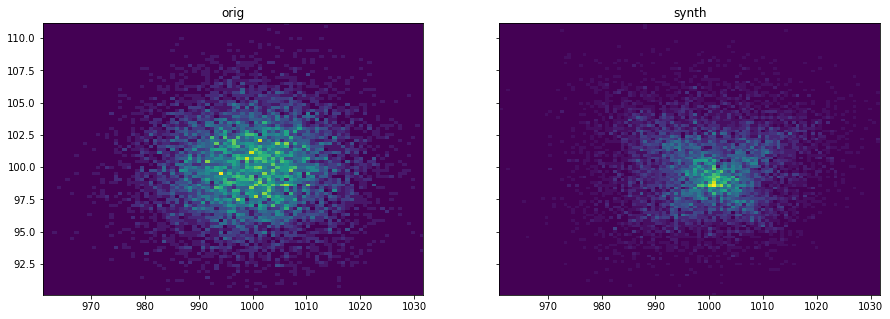

In [12]:
synthesize_and_plot(data, 'ball', metrics=default_metrics)

### Gauss "ball" around of zero

In [13]:
data = syn_dist.create_gauss_ball(x_mean=0, x_std=100, y_mean=0, y_std=10, size=10000)

took 7.520553827285767 s
Metrics:
avg_distance: 0.05505


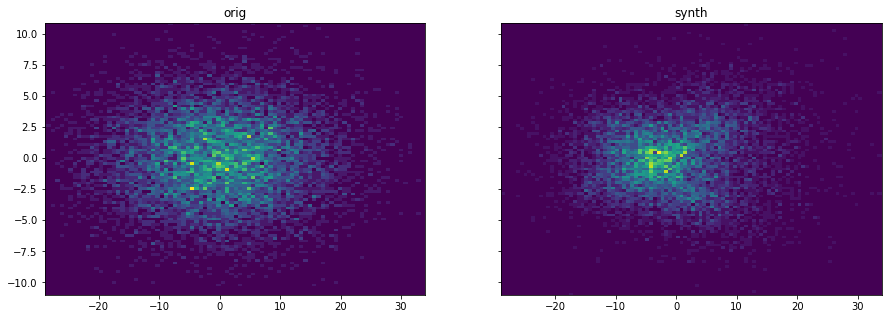

In [14]:
synthesize_and_plot(data, 'ball_ext', metrics=default_metrics)

### Correlated Gaussian far from zero

In [15]:
data = syn_dist.create_gauss_ball(x_mean=1000, x_std=100, y_mean=100, y_std=10, size=10000, cor=0.8)

TypeError: create_gauss_ball() got an unexpected keyword argument 'cor'

took 7.759300231933594 s


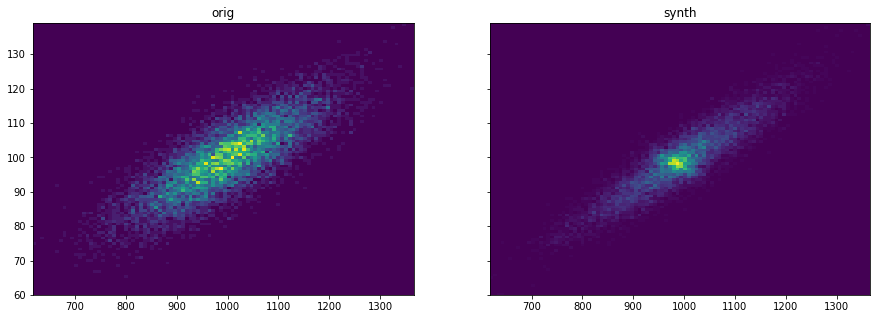

In [14]:
metrics = dict(default_metrics)
metrics["max_correlation_distance"] = max_correlation_distance
synthesize_and_plot(data, 'corr_ball_far', metrics=metrics)

### Correlated Gaussian around zero

In [15]:
data = syn_dist.create_gauss_ball(x_mean=0, x_std=100, y_mean=0, y_std=10, size=10000, cor=0.8)

took 7.44208288192749 s


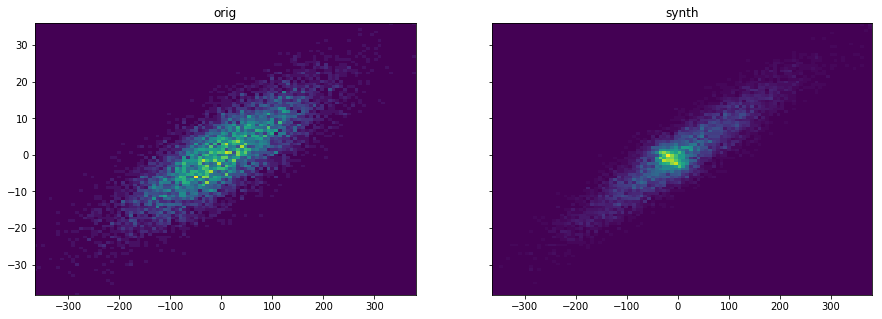

In [16]:
metrics = dict(default_metrics)
metrics["max_correlation_distance"] = max_correlation_distance
synthesize_and_plot(data, 'corr_ball_zero', metrics=metrics)

### Line of noise that far from zero

In [17]:
data = syn_dist.create_gauss_line(x_range=(0, 1000), intercept=100, slope=-0.1, y_std=10, size=10000)

took 7.7968456745147705 s
Metrics:
avg_distance: 0.06589999999999996


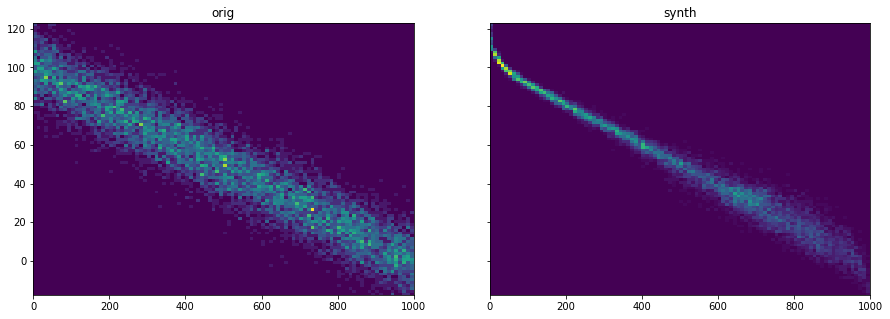

In [18]:
synthesize_and_plot(data, 'line', metrics=default_metrics)

### Line of noise that comes from zero

In [19]:
data = syn_dist.create_gauss_line(x_range=(0, 1000), intercept=0, slope=0.1, y_std=10, size=10000)

took 7.5168137550354 s
Metrics:
avg_distance: 0.07400000000000001


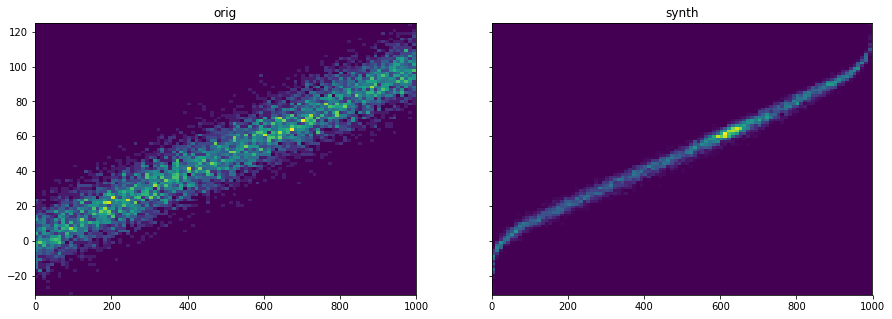

In [20]:
synthesize_and_plot(data, 'line_ext', metrics=default_metrics)

### Power law distribution

In [21]:
data = syn_dist.create_power_law_distribution(shape=0.5, scale=1000, size=10000)

took 7.168132066726685 s
Metrics:
avg_distance: 0.065


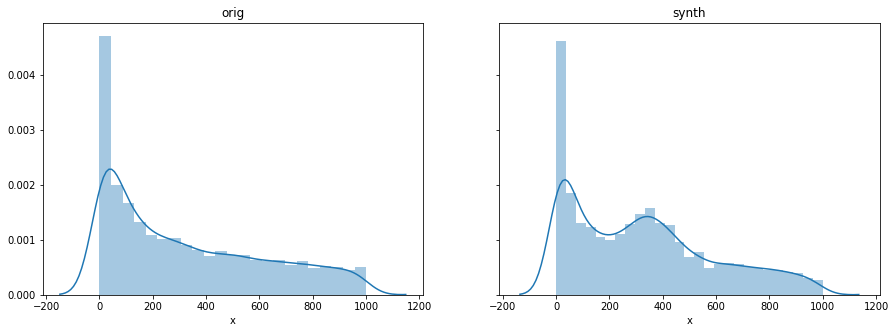

In [22]:
synthesize_and_plot(data, 'power_law', metrics=default_metrics)

### Conditional distribution

In [23]:
data = syn_dist.create_conditional_distribution((10,2), (20, 5), (30, 1), size=10000)

took 8.710633993148804 s


ValueError: color kwarg must have one color per data set. 2 data sets and 1 colors were provided

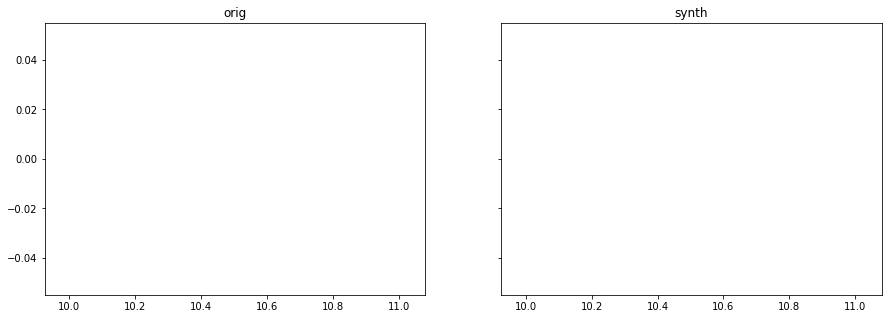

In [24]:
synthesize_and_plot(data, 'conditional', metrics=default_metrics)

### Bernoulli distribution

In [25]:
data = syn_dist.create_bernoulli(probability=0.5, size=10000)

took 8.292696714401245 s


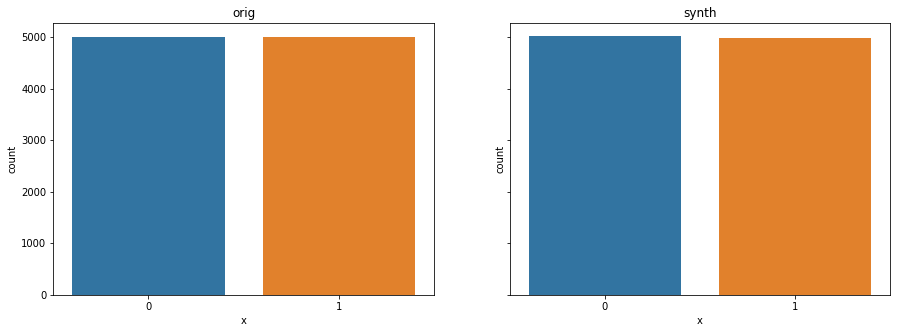

In [28]:
synthesize_and_plot(data, 'bernoulli_50/50', metrics=default_metrics)

In [29]:
data = syn_dist.create_bernoulli(probability=0.2, size=10000)

took 8.062379121780396 s


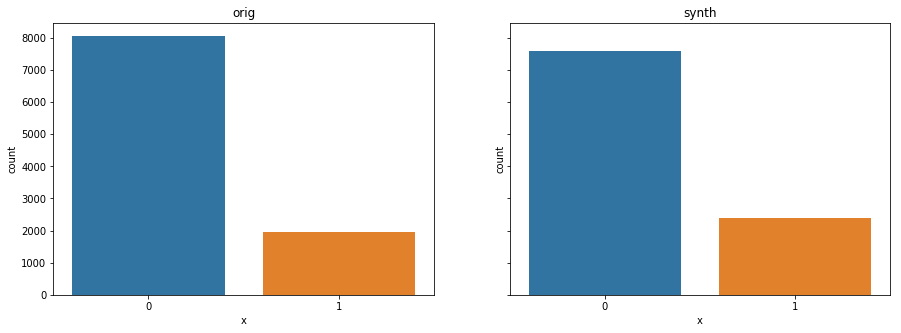

In [30]:
synthesize_and_plot(data, 'bernoulli_20/80', metrics=default_metrics)

### Categorical distribution

In [52]:
data = syn_dist.create_uniform_categorical(n_classes=100, size=100000)

took 43.56436777114868 s


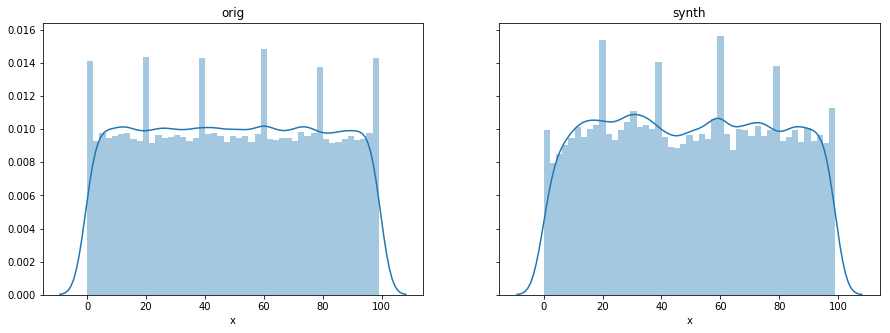

In [53]:
synthesize_and_plot(data, 'categorical_uniform', metrics=default_metrics, n_iter=10000)

In [33]:
data = syn_dist.create_power_law_categorical(n_classes=10, size=10000)

took 8.089760780334473 s


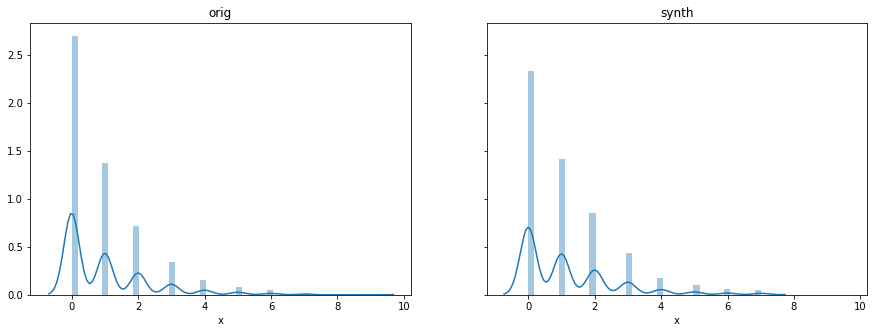

In [34]:
synthesize_and_plot(data, 'categorical_powerlaw', metrics=default_metrics)

In [35]:
data = syn_dist.create_mixed_continuous_categorical(n_classes=10, size=10000)

took 8.225680828094482 s


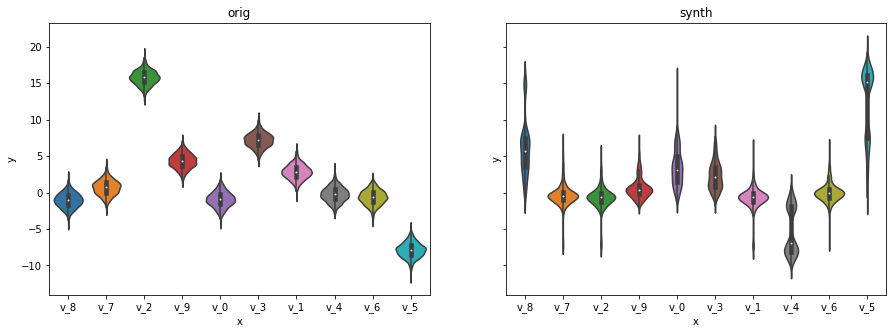

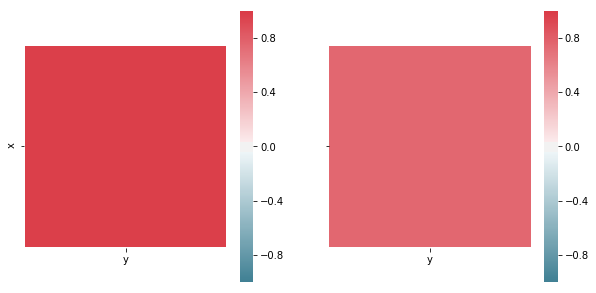

In [36]:
synthesize_and_plot(data, 'mixed_categorical_continuous', metrics=default_metrics, show_anova=True)

In [37]:
data = syn_dist.create_correlated_categorical(n_classes=10, size=10000, sd=1.)

took 8.996958017349243 s
         Current function value: 1.916201
         Iterations: 35
         Function evaluations: 111
         Gradient evaluations: 111


/Users/amandlamabona/anaconda3/envs/synth_p37/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 2.106872
         Iterations: 35
         Function evaluations: 113
         Gradient evaluations: 113


/Users/amandlamabona/anaconda3/envs/synth_p37/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


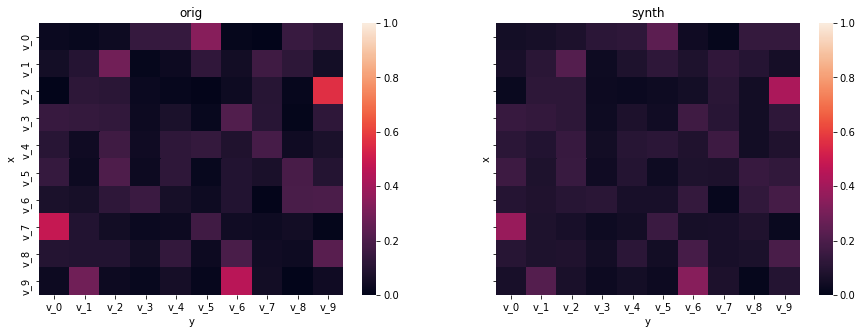

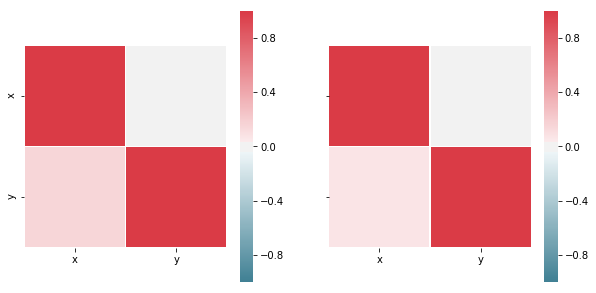

In [38]:
synthesize_and_plot(data, 'correlated_categoricals', metrics=default_metrics, show_cat_rsquared=True)

In [26]:
evaluation.write_metrics()